In [1]:
from agents.ppo import Agent, ReplayData, ExperimentReplayBuffer
from networks.vit import VIT3_FC
import matplotlib.pyplot as plt
from  env.guide_sim import GuidewireEnv
from env.metadata import GuideSimMetadata, HyperParams
import torch
import torchvision.transforms as transforms
import numpy as np 
import random
import os

pygame-ce 2.5.0 (SDL 2.30.3, Python 3.10.0)


In [2]:
dataset_path = "datas/exvivo/"
tasks = os.listdir(os.path.join(dataset_path, "task"))
tasks = [os.path.join(dataset_path, "task", t) for t in tasks]

In [3]:
hyper = HyperParams()
hyper.load_from_json("./hyper.json")

In [4]:
class SubEnv:
    """
    管理每个独立进程中的游戏环境
    每个进程会维护n个环境
    通过传入的tasks列表来创建环境
    环境使用串行方式来执行
    """
    def __init__(self, tasks, hyper_params:HyperParams):
        self.tasks = tasks
        self.envs = [GuidewireEnv(task) for task in tasks]
        self.dones = [False for _ in range(len(tasks))]
        self.hyper_params = hyper_params
        for env in self.envs:
            env.hyper_params = hyper_params
        self.last_states = []
        self.episode_buffer = [ReplayData() for _ in range(len(tasks))]
        self.replay_buffer = ExperimentReplayBuffer()

    # 重启环境
    def reset(self, transfrom: transforms.Compose) -> np.ndarray:
        """对每个子环境重置并且收集状态"""
        self.last_states = []
        states = None
        for k, env in enumerate(self.envs):
            s = env.reset()
            self.last_states.append(s)
            if states is None:
                states = np.zeros((len(self.tasks), *s.shape))
            states[k, ...] = s
        self.dones = [False for _ in range(len(self.tasks))]
        # 域随机化
        states = transfrom(
                torch.tensor(states, dtype=torch.uint8))
        states = states.numpy()
        return states

    # 环境执行一步
    def step(self, actions:list[int], 
             probs:list[float],
             values:list[float],
             transfrom: transforms.Compose):
        """对每个子环境串行执行操作并且收集状态"""
        states = []
        for k, env in enumerate(self.envs):
            s_next, r, d, _ = env.step(actions[k])
            self.episode_buffer[k].pack_step_data(self.last_states[k], 
                                                  actions[k], 
                                                  probs[k],
                                                  r,
                                                  values[k],
                                                  d)
            if d:  # 策略是如果结束了直接开一局新的
                s_next = env.reset()
                self.replay_buffer.pack_episode_data(self.episode_buffer[k],
                                                     self.hyper_params.lambda_,
                                                     self.hyper_params.gamma)
            # 域随机化
            s_next = transfrom(
                    torch.tensor(s_next, dtype=torch.uint8))
            s_next = s_next.numpy()

            states.append(s_next)
        self.last_states = states
        return np.array(states)
    
    def evaler(self, agent:Agent, transfrom: transforms.Compose):
        """评估模型，对所有的子环境都进行完整交互并且返回消耗步数和奖励"""
        agent.ac_model.eval()
        states = self.reset(transfrom)
        rewards = []
        steps = []
        out_states = []
        for k, env in enumerate(self.envs):
            num_steps = 0
            for _ in range(self.hyper_params.max_steps):
                a, _,_ = agent.desision(states[k])
                state, reward, done, _ = env.step(a)

                # 域随机化
                state = transfrom(
                    torch.tensor(state, dtype=torch.uint8))
                state = state.numpy()
                # 回到numpy
                states[k] = state

                num_steps += 1
                if done:
                    print(f"[eval] ID {k}: {env.task_path} done.")
                    print(f"\treward: {reward}, steps: {num_steps}")
                    rewards.append(reward)
                    steps.append(num_steps)
                    out_states.append(state)
                    break

        return out_states, np.mean(steps), np.mean(rewards)

## 创建批量交互器

In [5]:
se = SubEnv(tasks, hyper)

## 加载模型与PPO Agent

In [8]:
model = VIT3_FC()
count = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {count}")
agent = Agent(model)
agent.ac_model = model.to(agent.device)
agent.set_hyperpara(hyper)
agent.plot_attrs()

Total number of parameters: 27369478
cuda:0
Agent's attributes:
----------------------
batch_size :		 5
beta :		 0.02
c_coef :		 1.0
device :		 cuda:0
epoch :		 0
epsilon :		 0.2
exp_reuse_rate :		 10
gamma :		 0.98
lambda_ :		 0.99
lr :		 1e-06
optim_type :		 adam
optm :		 None
----------------------


# 一轮交互与收集过程

In [9]:
# 定义转换管道，包括域随机化
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 随机改变颜色属性
    transforms.RandomResizedCrop(size= (256, 256), scale=(0.95, 1.0)),  # 随机裁剪并调整大小
    transforms.RandomRotation(degrees=2),  # 随机旋转
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 无域随机化的普通转换管道
transform_norm = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.5], std=[0.5])  # 归一化到[-1, 1]之间
])


In [10]:
states = se.reset(transform)

(1.0, -1.0)

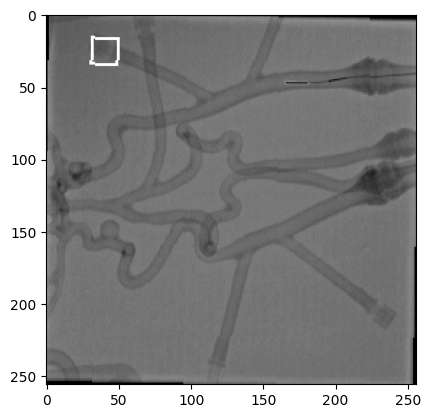

In [11]:
plt.imshow(states[0, 0], cmap="gray")
np.max(states[0, 0]), np.min(states[0, 0])

In [7]:
states = se.reset()

for _ in range(hyper.max_steps):
    batch_a_tensor, batch_p_tensor, batch_v_tensor, _ = agent.batch_desision(states)
    batch_a = batch_a_tensor.squeeze(1).tolist()
    batch_p = batch_p_tensor.squeeze(1).tolist()
    batch_v = batch_v_tensor.squeeze(1).tolist()
    states = se.step(batch_a, batch_p, batch_v)


Task ID 0: datas/exvivo/task\1.json done.
Task ID 1: datas/exvivo/task\10.json done.
Task ID 2: datas/exvivo/task\11.json done.
Task ID 3: datas/exvivo/task\12.json done.
Task ID 4: datas/exvivo/task\13.json done.
Task ID 5: datas/exvivo/task\14.json done.
Task ID 6: datas/exvivo/task\15.json done.
Task ID 7: datas/exvivo/task\16.json done.
Task ID 8: datas/exvivo/task\17.json done.
Task ID 9: datas/exvivo/task\18.json done.
Task ID 10: datas/exvivo/task\19.json done.
Task ID 11: datas/exvivo/task\2.json done.
Task ID 12: datas/exvivo/task\20.json done.
Task ID 13: datas/exvivo/task\21.json done.
Task ID 14: datas/exvivo/task\3.json done.
Task ID 15: datas/exvivo/task\4.json done.
Task ID 16: datas/exvivo/task\5.json done.
Task ID 17: datas/exvivo/task\6.json done.
Task ID 18: datas/exvivo/task\7.json done.
Task ID 19: datas/exvivo/task\8.json done.
Task ID 20: datas/exvivo/task\9.json done.


In [ ]:
for _ in range(hyper.num_epochs):
    states = se.reset()

    for _ in range(hyper.max_steps):
        batch_a_tensor, batch_p_tensor, batch_v_tensor, _ = agent.batch_desision(states)
        batch_a = batch_a_tensor.squeeze(1).tolist()
        batch_p = batch_p_tensor.squeeze(1).tolist()
        batch_v = batch_v_tensor.squeeze(1).tolist()
        states = se.step(batch_a, batch_p, batch_v)
    
    losses = agent.learn(se.replay_buffer)

In [12]:
def img_ploter(states:np.ndarray) -> plt.Figure:
    """将状态画成图，用于暂存到tensorboard中"""
    num_figs = 0
    if isinstance(states, np.ndarray):
        num_figs = states.shape[0]
    elif isinstance(states, list):
        num_figs = len(states)
    num_rows = num_figs // 5 + 1
    # 生成5列n行的子图
    fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
    now_row = 0
    for i, state in enumerate(states):
        # 每5个子图后换行
        axs[now_row, i%5].imshow(state[0], cmap="gray")
        axs[now_row, i%5].axis('off')
        if i%5 == 4:
            now_row += 1
    return fig


In [13]:
s, step, r, = se.evaler(agent, transform_norm)

[eval] ID 0: datas/exvivo/task\1.json done.
	reward: 1.7147984280919266, steps: 80
[eval] ID 1: datas/exvivo/task\10.json done.
	reward: 1.2378743560016174, steps: 80
[eval] ID 2: datas/exvivo/task\11.json done.
	reward: 2.375155785828881, steps: 80
[eval] ID 3: datas/exvivo/task\12.json done.
	reward: 0.789658080940789, steps: 80
[eval] ID 4: datas/exvivo/task\13.json done.
	reward: 0.9996723408132061, steps: 80
[eval] ID 5: datas/exvivo/task\14.json done.
	reward: 4.339856060457006, steps: 43
[eval] ID 6: datas/exvivo/task\15.json done.
	reward: 0.9969586349416099, steps: 80
[eval] ID 7: datas/exvivo/task\16.json done.
	reward: 1.410587053688935, steps: 80
[eval] ID 8: datas/exvivo/task\17.json done.
	reward: 1.0412872220488403, steps: 80
[eval] ID 9: datas/exvivo/task\18.json done.
	reward: 0.9755100915341263, steps: 80
[eval] ID 10: datas/exvivo/task\19.json done.
	reward: 1.1973282616072674, steps: 80
[eval] ID 11: datas/exvivo/task\2.json done.
	reward: 1.2801341652915, steps: 80

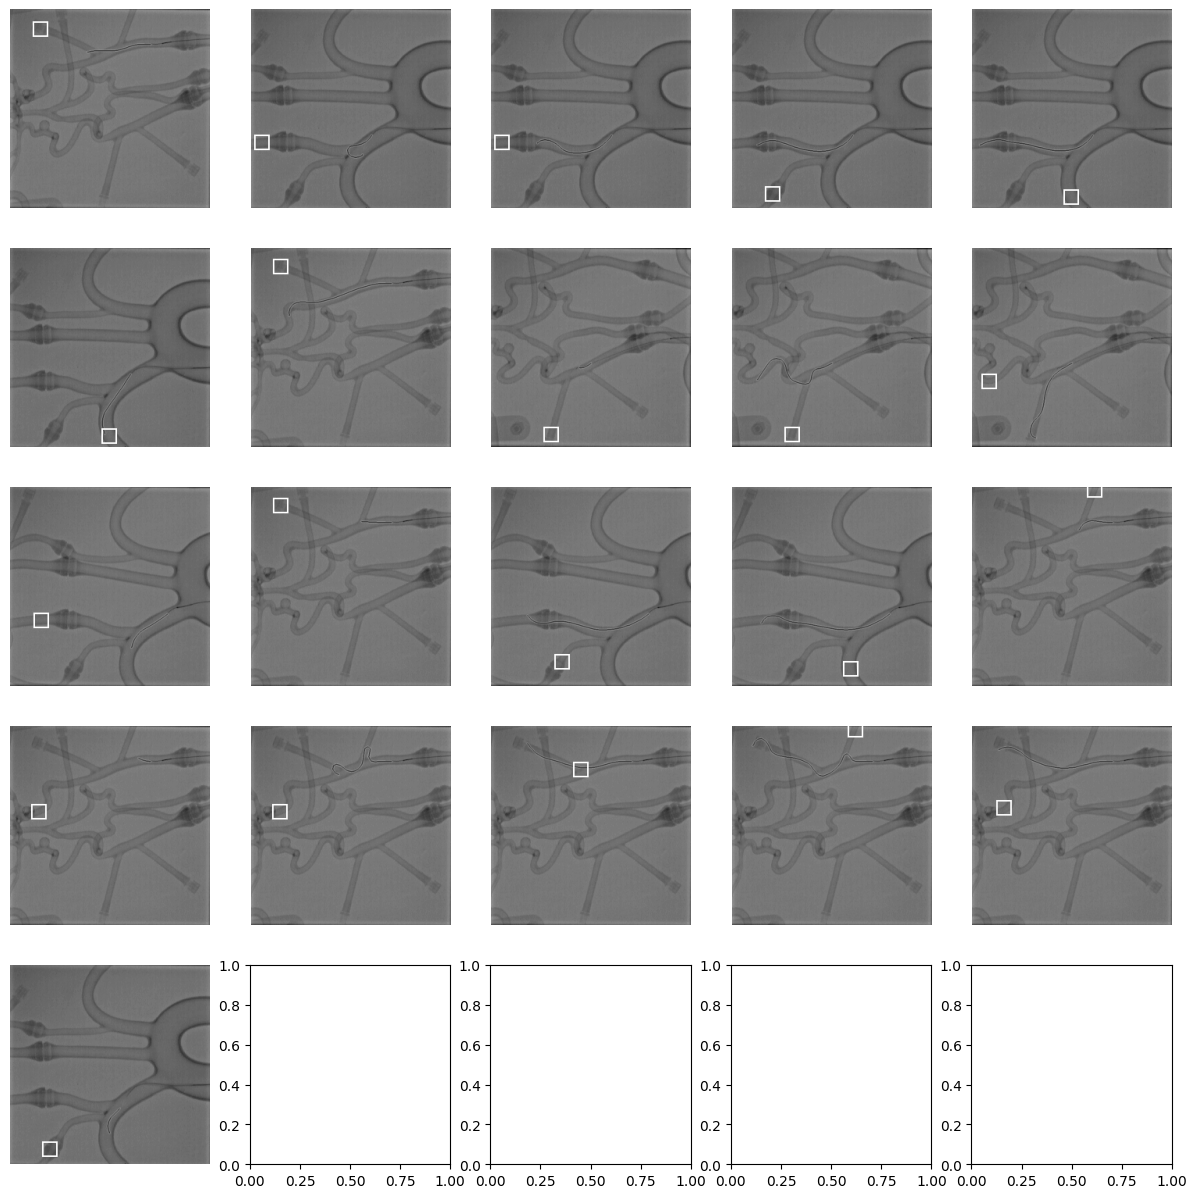

In [14]:
img_ploter(np.array(s))
plt.show()